In [111]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
#from prophet import Prophet

In [112]:
# Load the data from a CSV file
df = pd.read_csv("../data/pollofpolls.csv", sep=";")

In [113]:
#df

In [114]:
# Ensure the "Mnd" column is treated as a string (optional but recommended)
df["Mnd"] = df["Mnd"].astype(str)

# Create an empty dictionary for the predictions
predictions = {"Mnd": ["Februar-25", "Mars-25","April-25","Mai-25","Juni-25","Juli-25","August-25","September-25"]}


In [115]:
month_mapping = {
    "Januar": "January", "Februar": "February", "Mars": "March", "April": "April",
    "Mai": "May", "Juni": "June", "Juli": "July", "August": "August",
    "September": "September", "Oktober": "October", "November": "November", "Desember": "December"
}

# Replace Norwegian months with English
df["Mnd"] = df["Mnd"].replace(month_mapping, regex=True)

# Convert to datetime and set the date to the end of the month
df["Mnd"] = pd.to_datetime(df["Mnd"], format="%B-%y").dt.to_period("M").dt.to_timestamp("M")

# Sort values and set index
df = df.sort_values("Mnd")
df.set_index("Mnd", inplace=True)

#print(df)  # Check that dates are correctly formatted at month-end


In [116]:
# Perform ADF test on each party's time series
for party in ['Ap', 'Hoyre', 'Frp', 'SV', 'Sp', 'KrF', 'Venstre', 'MDG','Rodt', 'Andre']: 
    result = adfuller(df[party])
    print(f"{party} ADF Statistic: {result[0]}, p-value: {result[1]}")
    if result[1] > 0.05:
        print(f"Warning: {party} is not stationary, consider differencing.")

Ap ADF Statistic: -2.1431351909817096, p-value: 0.22752700223748779
Hoyre ADF Statistic: -1.8196635186008094, p-value: 0.37074392214204605
Frp ADF Statistic: 1.2116325044195977, p-value: 0.9960652755506311
SV ADF Statistic: -3.143500966393524, p-value: 0.023496976073433522
Sp ADF Statistic: -3.1838888208581144, p-value: 0.02093640394522018
KrF ADF Statistic: -4.707234698517839, p-value: 8.155841832630618e-05
Venstre ADF Statistic: -1.9660630228172478, p-value: 0.30164858101469527
MDG ADF Statistic: -2.585936634044432, p-value: 0.09593885432671917
Rodt ADF Statistic: -3.0468191741656767, p-value: 0.030747424499184044
Andre ADF Statistic: -1.8129280146418307, p-value: 0.3740624451383301


In [117]:
df_diff = df.diff().dropna()  # Difference to make stationary

In [118]:
model = VAR(df_diff)  # Use df_diff if differenced data is needed
model_fitted = model.fit(24)  # Choose lag order (5 is an example, tune this)

# Display the summary of the fitted model
#print(model_fitted.summary())

C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


In [119]:
forecast = model_fitted.forecast(df_diff.values[-model_fitted.k_ar:], steps=8)

# Convert forecasted values to a DataFrame
forecast_dates = pd.date_range(start="2025-02-28", periods=8, freq='ME')
forecast_diff_df = pd.DataFrame(forecast, index=forecast_dates, columns=df.columns)

print(forecast_df)

                  Ap     Hoyre       Frp        SV        Sp       KrF  \
2025-02-28 -0.163995 -0.851972  2.085607 -0.157860  0.490251  0.090149   
2025-03-31 -0.846584  1.351405  1.957488 -0.568862 -0.156772 -0.486551   
2025-04-30 -0.860863  1.121713 -0.057800 -0.079456 -0.253976 -0.611900   
2025-05-31 -1.376012 -0.436038  1.244922 -0.426203 -0.024013  0.101942   
2025-06-30 -0.119481 -0.750352  1.429706 -0.455350  0.141898  0.029299   
2025-07-31 -0.411784  1.039609  1.255947 -1.314777 -0.551430  0.365279   
2025-08-31 -0.577505  0.971894  1.047158 -0.998204  1.128608 -0.181602   
2025-09-30 -0.814860  0.122954  3.230794 -0.724380  1.069915 -0.396893   

             Venstre       MDG      Rodt     Andre  
2025-02-28 -0.571916  0.029435 -0.183999 -0.602522  
2025-03-31 -0.276313 -0.544253  0.369416 -0.777930  
2025-04-30 -0.346057  0.443308 -0.078781  0.682210  
2025-05-31  0.071857 -0.228238  1.417877 -0.692074  
2025-06-30 -0.330738 -0.203193  0.127697  0.335839  
2025-07-31 -0.3

In [120]:
# Invert differencing (cumulative sum and add back the last observed value)
forecast_original_scale = forecast_diff_df.cumsum() + df.iloc[-1]

In [121]:
forecast_original_scale

,Ap,Hoyre,Frp,SV,Sp,KrF,Venstre,MDG,Rodt,Andre
2025-02-28,18.304740,22.730403,24.537788,8.113346,5.967810,3.407195,4.358651,3.137411,5.780379,3.727742
2025-03-31,17.938411,23.773291,25.037805,7.807170,5.593044,3.345313,4.227913,3.112690,5.797132,3.323675
2025-04-30,18.184503,24.778373,24.354131,7.290923,5.958114,3.124780,3.845080,3.323508,5.643741,3.404124
2025-05-31,17.411219,24.622693,26.189348,6.945098,5.989536,3.233324,3.925291,3.212896,5.721424,2.677078
2025-06-30,16.995980,24.470722,27.933294,6.491260,5.685006,3.223965,3.760667,3.150022,5.846868,2.390164
2025-07-31,17.305802,24.159971,28.475607,5.807820,5.904141,3.158767,3.546328,3.299089,5.700659,2.704428
2025-08-31,17.159814,24.169927,29.772984,5.493081,5.821074,3.244649,3.127135,3.095659,5.485417,2.708984
2025-09-30,17.380016,24.255374,29.989945,5.018668,5.831069,3.077150,3.056675,3.165650,5.250586,2.989332


<Figure size 1200x600 with 0 Axes>

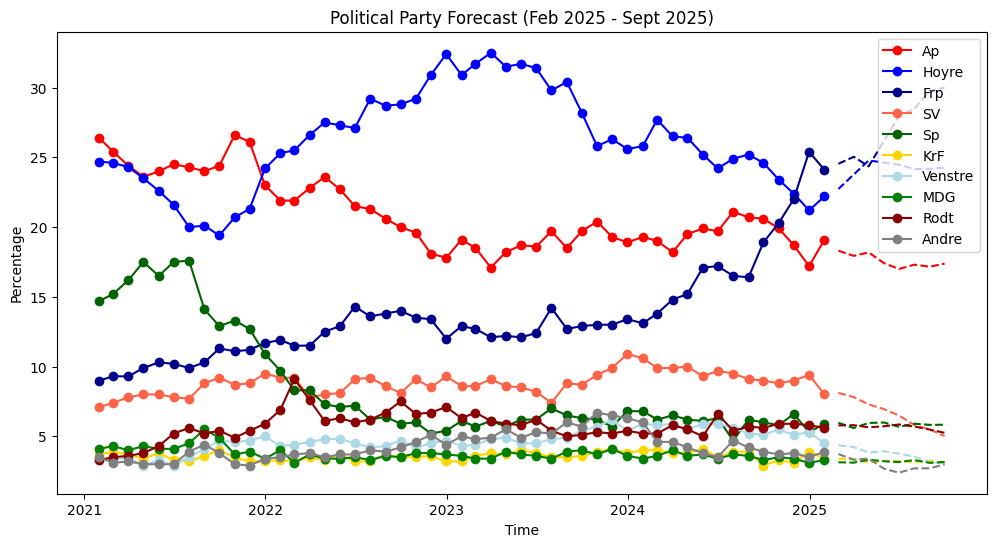

In [122]:
plt.figure(figsize=(12, 6))


# Define a color map for consistency
colors = {
    'Ap': '#FF0000',        # Red
    'Hoyre': '#0000FF',     # Blue
    'Frp': '#00008B',       # Dark Blue
    'SV': '#FF6347',        # Light Red (Tomato)
    'Sp': '#006400',        # Dark Green
    'KrF': '#FFD700',       # Yellow (Gold)
    'Venstre': '#ADD8E6',   # Light Blue
    'MDG': '#008000',       # Green
    'Rodt': '#8B0000',      # Dark Red
    'Andre': '#808080'      # Gray
}


plt.figure(figsize=(12, 6))

for party in ['Ap', 'Hoyre', 'Frp', 'SV', 'Sp', 'KrF', 'Venstre', 'MDG','Rodt', 'Andre']:
    color = colors.get(party, np.random.rand(3,))  # Use predefined color or random if missing
    
    # Plot actual data
    plt.plot(df.index, df[party], marker="o", color=color, label=f"{party}")

    # Plot forecast with the same color
    plt.plot(forecast_original_scale.index, forecast_original_scale[party], linestyle="dashed", color=color)

plt.xlabel("Time")
plt.ylabel("Percentage")
plt.title("Political Party Forecast (Feb 2025 - Sept 2025)")
plt.legend()
plt.show()

In [123]:
forecast_df

,Ap,Hoyre,Frp,SV,Sp,KrF,Venstre,MDG,Rodt,Andre
2025-02-28,-0.163995,-0.851972,2.085607,-0.157860,0.490251,0.090149,-0.571916,0.029435,-0.183999,-0.602522
2025-03-31,-0.846584,1.351405,1.957488,-0.568862,-0.156772,-0.486551,-0.276313,-0.544253,0.369416,-0.777930
2025-04-30,-0.860863,1.121713,-0.057800,-0.079456,-0.253976,-0.611900,-0.346057,0.443308,-0.078781,0.682210
2025-05-31,-1.376012,-0.436038,1.244922,-0.426203,-0.024013,0.101942,0.071857,-0.228238,1.417877,-0.692074
2025-06-30,-0.119481,-0.750352,1.429706,-0.455350,0.141898,0.029299,-0.330738,-0.203193,0.127697,0.335839
2025-07-31,-0.411784,1.039609,1.255947,-1.314777,-0.551430,0.365279,-0.318441,-0.267374,-0.093280,0.431680
2025-08-31,-0.577505,0.971894,1.047158,-0.998204,1.128608,-0.181602,-1.064719,-0.139161,-0.030326,-0.033711
2025-09-30,-0.814860,0.122954,3.230794,-0.724380,1.069915,-0.396893,-0.598203,-0.507797,-0.866985,-0.408019
